# **Seq2Seq Model - Document Summarization**

### **1. Import data**

The dataset consists of NEWS SUMMARY dataset (by KONDALARAO VONTERU) and CNN-DailyMail News (by GOWRI SHANKAR P).

In [10]:
import pandas as pd

path = 'data/'

raw_text = pd.read_csv(path + "news_summary_more.csv", encoding='iso-8859-1')
summary = pd.read_csv(path + "news_summary.csv", encoding='iso-8859-1')
cnn_text = pd.read_csv(path + "cnn_news.csv", encoding='iso-8859-1')

In [11]:
cnn_text.head(2) # to see the columns name of different dataset

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...


In [12]:
raw_prep = raw_text.iloc[:, 0:2].copy()
sum_prep = summary.iloc[:, 0:6].copy()

sum_prep['text'] = sum_prep['author'].str.cat(\
                   sum_prep['date'].str.cat(\
                   sum_prep['read_more'].str.cat(\
                   sum_prep['text'].str.cat(\
                   sum_prep['ctext'], sep=' '), sep=' '), sep=' '), sep=' ')

df = pd.DataFrame()
df['text'] = pd.concat([raw_prep['text'], sum_prep['text'], cnn_text['article']], ignore_index=True)
df['summary'] = pd.concat([raw_prep['headlines'], sum_prep['headlines'], cnn_text['highlights']], ignore_index=True)
# df['text'] = pd.concat([raw_prep['text'], sum_prep['text']], ignore_index=True)
# df['summary'] = pd.concat([raw_prep['headlines'], sum_prep['headlines']], ignore_index=True)

In [13]:
df.head(3)

,text,summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...


### **2. Cleaning data**

Remove non-alphabetic characters from the dataset using regular expression library

In [14]:
import re

# Define function to clean data (ref: blog.paperspace)
def text_strip(col):
    for row in col:
        row = re.sub("(\\t)", " ", str(row)).lower()
        row = re.sub("(\\r)", " ", str(row)).lower()
        row = re.sub("(\\n)", " ", str(row)).lower()

        # Remove _ if it occurs more than one time consecutively
        row = re.sub("(__+)", " ", str(row)).lower()

        # Remove - if it occurs more than one time consecutively
        row = re.sub("(--+)", " ", str(row)).lower()

        # Remove ~ if it occurs more than one time consecutively
        row = re.sub("(~~+)", " ", str(row)).lower()

        # Remove + if it occurs more than one time consecutively
        row = re.sub("(\+\++)", " ", str(row)).lower()

        # Remove . if it occurs more than one time consecutively
        row = re.sub("(\.\.+)", " ", str(row)).lower()

        # Remove the characters - <>()|&©ø"',;?~*!
        row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(row)).lower()

        # Remove mailto:
        row = re.sub("(mailto:)", " ", str(row)).lower()

        # Remove \x9* in text
        row = re.sub(r"(\\x9\d)", " ", str(row)).lower()

        # Replace INC nums to INC_NUM
        row = re.sub("([iI][nN][cC]\d+)", "INC_NUM", str(row)).lower()

        # Replace CM# and CHG# to CM_NUM
        row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(row)).lower()

        # Remove punctuations at the end of a word
        row = re.sub("(\.\s+)", " ", str(row)).lower()
        row = re.sub("(\-\s+)", " ", str(row)).lower()
        row = re.sub("(\:\s+)", " ", str(row)).lower()

        # Replace any url to only the domain name
        try:
            url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", str(row))
            repl_url = url.group(3)
            row = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, str(row))
        except:
            pass

        # Remove multiple spaces
        row = re.sub("(\s+)", " ", str(row)).lower()

        # Remove the single character hanging between any two spaces
        row = re.sub("(\s+.\s+)", " ", str(row)).lower()

        yield row

Clean the data by calling functions

In [15]:
cleaned_text = text_strip(df['text'])
cleaned_summary = text_strip(df['summary'])

Load data as batches (using **spacy**) and enclosed the summaries with starting and closing tokens

In [16]:
import spacy
from time import time


nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
print("Successfully load spaCy model (effiency)")

text = [str(raw) for raw in nlp.pipe(cleaned_text, batch_size = 500, n_process=2)]
print("spaCy process for texts: Done")

summary = ['_START_' + str(raw) + '_END_' for raw in nlp.pipe(cleaned_summary, batch_size=500, n_process=2)]
print("spaCy process for summaries: Done")

Successfully load spaCy model (effiency)
spaCy process for texts: Done
spaCy process for summaries: Done


The `_START_` and `_END_` tokens are used to determine the starting and ending points of the summaries, in which it could also be helpful to exclude the empty text.

In [17]:
print(f"Original text\n{raw_prep.text[0]}\n\nSample text\n{text[0]}\n\nSummary\n{summary[0]}")

Original text
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.

Sample text
saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad 360-degree career support helped him transition to data scientist at tech mahindra with 90% salary hike upgrad online power learning has powered lakh+ careers.

Summary
_START_upgrad learner switches to career in ml al with 90% salary hike_END_


### **3. Examine the data**

We will analyze the characteristics of the dataset, such as: maximum sequence lengths, most-frequent words, difference in length between raw texts and summaries.

In [18]:
df['cleaned_text'] = pd.Series(text)
df['cleaned_summary'] = pd.Series(summary)

In [43]:
# Save the data so we don't need to run spaCy again in the future
df.to_csv('data/cleaned_data.csv', index=False)

After creating the list of texts and summaries, we will split each sequences to a list consisting multiple words by using `split' built-in function. From the lists we have created, a graph will be drawn to determine the range of length, from which we can derive the maximum number of words that frequently fall into.

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

text_cnt = []
sum_cnt = []

for text_seq, sum_seq in zip(df['cleaned_text'], df['cleaned_summary']):
    text_cnt.append(len(text_seq.split()))
    sum_cnt.append(len(sum_seq.split()))

plot_df = pd.DataFrame()
plot_df['text'] = text_cnt
plot_df['summary'] = sum_cnt

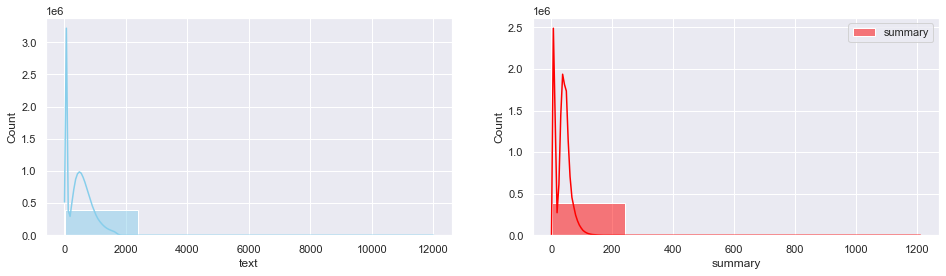

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
sns.histplot(data=plot_df, x="text", color="skyblue", label="text", kde=True, bins=5, ax=ax[0])
sns.histplot(data=plot_df, x="summary", color="red", label="summary", kde=True, bins=5, ax=ax[1])

plt.legend() 
plt.show()

From the plot, we can confidently determine the maximum length of summaries would be 15 words. On the other hand, it seems like the range of texts is barely observerable. As said, we will use the violin plot to see the distribution density and determine the maximum length among them.

In [21]:
plot_df['text'].describe()

count    390028.000000
mean        504.556178
std         381.093919
min           1.000000
25%          61.000000
50%         476.000000
75%         740.250000
max       11999.000000
Name: text, dtype: float64

In [47]:
plot_df['summary'].describe()

count    390028.000000
mean         37.860113
std          23.986523
min           1.000000
25%          12.000000
50%          38.000000
75%          51.000000
max        1211.000000
Name: summary, dtype: float64

Since the data is heavily right skewed, we could remove some of the outliers by slicing (for visualization purpose only of course)

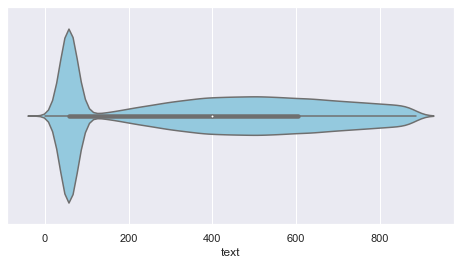

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.violinplot(data=plot_df[plot_df.text < plot_df.text.mean() + plot_df.text.std()], x="text", color="skyblue", label="text", ax=ax)
plt.show()

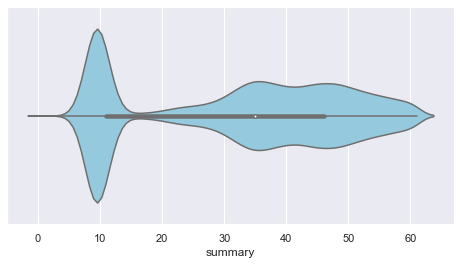

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.violinplot(data=plot_df[plot_df.summary < plot_df.summary.mean() + plot_df.summary.std()], x="summary", color="skyblue", label="text", ax=ax)
plt.show()

The frequent lengths of texts fall into around 50 - 60 words. From here, we can assume the maximum length of texts to be 100 words, as almost sequences fall into the range below 100. But most of the input from users may not too short like that, so I decided to double the maximum length upto 200 words, just in case.

In [60]:
# Initialize the plausible length for texts and summaries
max_text_len = 800
max_sum_len = 60

### **4. Select plausible texts and summaries**

In this section, we will select plausible texts and summaries for further training progress based on the length criteria proposed above.

In [61]:
import numpy as np

# We convert the dataframe to numpy for faster process
cleaned_text = np.array(df['cleaned_text'])
cleaned_summary = np.array(df['cleaned_summary'])

processed_text = []
processed_sum = []

for text, summary in zip(cleaned_text, cleaned_summary):
    if len(text.split()) <= max_text_len and len(summary.split()) <= max_sum_len:
        processed_text.append(text)
        processed_sum.append(summary)

post_processed_df = pd.DataFrame({'text': processed_text, 'summary': processed_sum})
post_processed_df.head(3)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,_START_upgrad learner switches to career in ml...
1,kunal shah credit card bill payment platform c...,_START_delhi techie wins free food from swiggy...
2,new zealand defeated india by wickets in the f...,_START_new zealand end rohit sharma-led india ...


In [62]:
print(f"Pre-processed dataset\n{len(df)} sequences\nPost-processed dataset\n{len(post_processed_df)} sequences")

Pre-processed dataset
390028 sequences
Post-processed dataset
280344 sequences


Now, we add the indicator of starting point (`sot`: start of token) and ending point (`eot`: end of token) of sequence. This would help to determine the correct sequence during the tokenization phase.

Speaking of tokenization, it is a way of seperating a piece of text into smaller units called tokens (can be either characters, words or sub-words). For example, we want tokenize the sequence "Code is fun" by remove the space delimeter. So it would become 3 different words: 'Code', 'is' and 'fun', which is also results of words tokenization.

Another example would be tokenize the word "science" into s-c-i-e-n-c-e with characters tokenization, or into sc-ience with subwords tokenization (or n-gram).

Tokenization is performed on the corpus (documents/dataset/sequence) to obtain tokens, and these tokens will be feed to the formation of vocabulary which is a set of unique tokens in the corpus. Note that the `sok` and `eos` are different from `_START_` and `_END_` notations since the later tokens are used to remove empty sequences.

In [63]:
post_processed_df['summary'] = post_processed_df['summary'].apply(lambda x: 'sot ' + x + ' eot')

### **5. Tokenizing the dataset**

Forming the train and test dataset

In [64]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(post_processed_df["text"]),
    np.array(post_processed_df["summary"]),
    test_size=0.2,
    random_state=0,
    shuffle=True,
)

In [65]:
# Tokenize the text to get the vocabulary, using keras libraries
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare a tokenizer on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [66]:
# Print out some tokens from the tokenizer
i = 5
for key, value in x_tokenizer.word_counts.items():
    if i == 0: break
    print(key, value)
    i-=1

after 256888
the 4538277
us 55428
government 59958
told 103413


Excluding the very rare words

In [69]:
thresh = 5 # occurs less than 5 times

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

% of rare words in vocabulary:  65.9886578255343


Since the rare words occupied the most in the vocabulary, we will tokenize the dataset again by using the total number of words minus the rare words.

After that, by using the built-in function from keras, we will convert the text into number sequences, and padding the zeroes to ensure all sequences have the same length (which equal to the maximum length)

In [70]:
# Prepare a tokenizer but exclude the rare words
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences to integer sequences 
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print(f"Size of vocabulary in the text corpus {x_voc}")

Size of vocabulary in the text corpus 132182


Now let's prepare the tokenizer for summaries

In [71]:
# Prepare a tokenizer on training data
y_tokenizer = Tokenizer() 
y_tokenizer.fit_on_texts(list(y_tr))

thresh = 5 # occurs less than 5 times

cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

# Prepare a tokenizer but exclude the rare words
y_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

# Convert text sequences to integer sequences 
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val)

# Pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq,  maxlen=max_sum_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_sum_len, padding='post')

# Size of vocabulary (+1 for padding token)
y_voc = y_tokenizer.num_words + 1

print(f"Size of vocabulary in the summary corpus {y_voc}")

% of rare words in vocabulary:  67.5746349967313
Size of vocabulary in the summary corpus 40177


### **6. Remove empty sequences**

As we have disscued in preivous section, we will remove all empty summaries (which only have START and END tokens) and their associated texts from the data.

In [72]:
# Remove empty summaries, which only have 'START' and 'END' tokens
index = []
# Append the indices of empty sequences and remove with numpy
for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        index.append(i)

y_tr = np.delete(y_tr, index, axis=0)
x_tr = np.delete(x_tr, index, axis=0)

Apply the same process for validation dataset

In [75]:
# Remove empty summaries, which only have 'START' and 'END' tokens
index = []
# Append the indices of empty sequences and remove with numpy
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        index.append(i)

y_val = np.delete(y_val, index, axis=0)
x_val = np.delete(x_val, index, axis=0)

### **7. Construct the model**

As the data is well-prepared until now, we will move on to create the model structure with the Tensorflow and Keras libraries

In [90]:
# Import libraries for constructing models
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

The Seq2Seq consist of encoders and decoders in its network. In the next cells, we will define the encoder and decoder pipelines and then assemble them together in the future steps.

#### **Model establishment**

In [91]:
latent_dim = 300
embedding_dim = 200
rcurr_dropout = 0 # set to 0 for cuDNN implementation

# Encoder
encoder_inputs = Input(shape=(max_text_len, ), name="encoder_inputs")

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim, trainable=True, name="encoder_embeddings")(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=rcurr_dropout, name="encoder_lstm1")
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=rcurr_dropout, name="encoder_lstm2")
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=rcurr_dropout, name="encoder_lstm3")
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ), name="decoder_inputs")

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True, name="decoder_embeddings")
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=rcurr_dropout, name="decoder_lstm")
(decoder_outputs, decoder_fwd_state, decoder_back_state) = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'), name="dense")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name="training_model")

model.summary()

Model: "training_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 800)]        0           []                               
                                                                                                  
 encoder_embeddings (Embedding)  (None, 800, 200)    26436400    ['encoder_inputs[0][0]']         
                                                                                                  
 encoder_lstm1 (LSTM)           [(None, 800, 300),   601200      ['encoder_embeddings[0][0]']     
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                     

#### **Restore tokenizer, weight and model(hidden section)**

In [ ]:
# # Load text and summary tokenizer
# with open('model/text_tokenizer.pickle', 'rb') as handle:
#     x_tokenizer = pickle.load(handle)

# with open('model/sum_tokenizer.pickle', 'rb') as handle:
#     y_tokenizer = pickle.load(handle)

# # Load the weights
# w_encoder_embeddings = np.load('model/encoder_embeddings.npz', allow_pickle=True)
# w_decoder_embeddings = np.load('model/decoder_embeddings.npz', allow_pickle=True)
# w_encoder_lstm1 = np.load('model/encoder_lstm1.npz', allow_pickle=True)
# w_encoder_lstm2 = np.load('model/encoder_lstm2.npz', allow_pickle=True)
# w_encoder_lstm3 = np.load('model/encoder_lstm3.npz', allow_pickle=True)
# w_decoder_lstm = np.load('model/decoder_lstm.npz', allow_pickle=True)
# w_dense = np.load('model/dense.npz', allow_pickle=True)

# x_voc = x_tokenizer.num_words + 1
# y_voc = y_tokenizer.num_words + 1

In [ ]:
# latent_dim = 300
# embedding_dim = 200

# # Encoder
# encoder_inputs = Input(shape=(max_text_len, ), name="encoder_inputs")

# # Embedding layer
# enc_emb = Embedding(x_voc, embedding_dim, trainable=True, name="encoder_embeddings")(encoder_inputs)

# # Encoder LSTM 1
# encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
#                      return_state=True, dropout=0.4,
#                      recurrent_dropout=0.4, name="encoder_lstm1")
# (encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# # Encoder LSTM 2
# encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
#                      return_state=True, dropout=0.4,
#                      recurrent_dropout=0.4, name="encoder_lstm2")
# (encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# # Encoder LSTM 3
# encoder_lstm3 = LSTM(latent_dim, return_state=True,
#                      return_sequences=True, dropout=0.4,
#                      recurrent_dropout=0.4, name="encoder_lstm3")
# (encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# # Set up the decoder, using encoder_states as the initial state
# decoder_inputs = Input(shape=(None, ), name="decoder_inputs")

# # Embedding layer
# dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True, name="decoder_embeddings")
# dec_emb = dec_emb_layer(decoder_inputs)

# # Decoder LSTM
# decoder_lstm = LSTM(latent_dim, return_sequences=True,
#                     return_state=True, dropout=0.4,
#                     recurrent_dropout=0.2, name="decoder_lstm")
# (decoder_outputs, decoder_fwd_state, decoder_back_state) = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# # Dense layer
# decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'), name="dense")
# decoder_outputs = decoder_dense(decoder_outputs)

# # Define the model
# loaded_model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name="training_model")

# loaded_model.summary()

In [1]:
# loaded_model.layers[2].set_weights(w_encoder_embeddings['arr_0'])
# loaded_model.layers[3].set_weights(w_decoder_embeddings['arr_0'])
# loaded_model.layers[4].set_weights(w_encoder_lstm1['arr_0'])
# loaded_model.layers[5].set_weights(w_encoder_lstm2['arr_0'])
# loaded_model.layers[6].set_weights(w_encoder_lstm3['arr_0'])
# loaded_model.layers[7].set_weights(w_decoder_lstm['arr_0'])
# loaded_model.layers[8].set_weights(w_dense['arr_0'])

### **8. Train the model**

Configure GPUs

In [102]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [106]:
tf.debugging.set_log_device_placement(True)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Virtual devices cannot be modified after being initialized


Train model

Input = texts (all) and summaries (all excluding the last word)

Output = summaries (starting from 2nd word to last word) -> serve the purpose of predicting on next word in summary

In [107]:
n_epochs = 50
n_batch_size = 32

In [109]:
try:
  # Specify an invalid GPU device
  with tf.device('/device:GPU:0'):
        # Optimizer and loss function
        model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

        history = model.fit(
            [x_tr, y_tr[:, :-1]], 
            y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
            epochs=n_epochs,
            callbacks=[es],
            batch_size=n_batch_size,
            validation_data=([x_val, y_val[:, :-1]],
                            y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:])
            )
except RuntimeError as e:
  print(e)

Epoch 1/50
7009/7009 [==============================] - 4453s 633ms/step - loss: 3.4452 - val_loss: 3.2467
Epoch 2/50
7009/7009 [==============================] - 4422s 631ms/step - loss: 3.2334 - val_loss: 3.1504
Epoch 3/50
7009/7009 [==============================] - 4426s 631ms/step - loss: 3.1768 - val_loss: 3.1098
Epoch 4/50
7009/7009 [==============================] - 4410s 629ms/step - loss: 3.1256 - val_loss: 3.0823
Epoch 5/50
7009/7009 [==============================] - 4412s 630ms/step - loss: 3.0665 - val_loss: 2.9995
Epoch 6/50
7009/7009 [==============================] - 4412s 629ms/step - loss: 3.0179 - val_loss: 2.9770
Epoch 7/50
7009/7009 [==============================] - 4459s 636ms/step - loss: 2.9808 - val_loss: 2.9438
Epoch 8/50
7009/7009 [==============================] - 4407s 629ms/step - loss: 2.9465 - val_loss: 2.9427
Epoch 9/50
7009/7009 [==============================] - 4408s 629ms/step - loss: 2.9153 - val_loss: 2.9345
Epoch 10/50
7009/7009 [==============

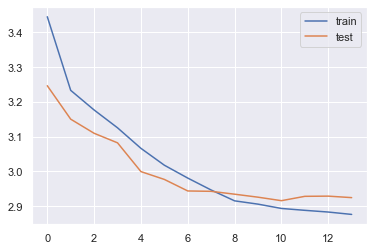

In [110]:
sns.lineplot(x=range(0, len(history.history['loss'])), y=history.history['loss'], label='train')
sns.lineplot(x=range(0, len(history.history['loss'])), y=history.history['val_loss'], label='test')

plt.legend()
plt.show()

### **9. Save model layers and weights**

In [111]:
# Save the text and summary tokenizer
import pickle

with open('model/text_tokenizer.pickle', 'wb') as handle:
    pickle.dump(x_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('model/sum_tokenizer.pickle', 'wb') as handle:
    pickle.dump(y_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the weights individually
for layer in model.layers:
    weights = layer.get_weights()
    if weights != []:
        np.savez(f'model/{layer.name}.npz', weights)

c:\Users\Bin\anaconda3\lib\site-packages\numpy\lib\npyio.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


### **10. Inference model**

In [112]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [113]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs) # Reuse the defined decoder Embedding layer

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) # Reuse the defined TimeDistributed Dense layer

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [114]:
def decode_sequence(input_seq):
    # Encode the input sequence
    (enc_out, enc_h, enc_c) = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1
    target_seq = np.zeros((1,1))
    # Populate the first word of target sequence with the 'start of token' word
    target_seq[0, 0] = target_word_index['sot']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq] + [enc_out, enc_h, enc_c])

        # Sample a token, predict the upcoming word by choosing the one with highest probability attached
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eot':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the 'end of token' word.
        if sampled_token == 'eot' or len(decoded_sentence.split()) >= max_sum_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (enc_h, enc_c) = (h, c)

    return decoded_sentence

In [115]:
# Convert sequence to summary by looking up the reversed map of word to indices (i.e: 'word': index)
# Note: sequence is in numerical form
def seq2sum(input_seq):
    newText = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sot'] and i != target_word_index['eot']:
            newText = newText + reverse_target_word_index[i] + ' '
    
    return newText

# Convert sequence to summary by looking up the reversed map of word to indices (i.e: 'word': index)
# Note: sequence is in numerical form
def seq2text(input_seq):
    newText = ''
    for i in input_seq:
        if i != 0:
            newText = newText + reverse_source_word_index[i] + ' '

    return newText

### **11. Prediction tests**

In [116]:
def summary_predictions(num_of_tests):
    for i in range(0, num_of_tests):
        print('Text:', seq2text(x_tr[i]))
        print('Original summary:', seq2sum(y_tr[i]))
        print('Predicted summary:', decode_sequence(x_tr[i].reshape(1, max_text_len)))
        print('\n')

In [117]:
n_of_tests = 10
summary_predictions(n_of_tests)

Text: after the us government told india and other countries to cut oil imports from iran to zero or face sanctions the congress asked prime minister narendra modi if india would adhere to the order it asked will the prime minister and petroleum minister tell the nation its impact on petrol prices and national interests iran is india third largest oil supplier 
Original summary: start will pm stop oil imports from iran as directed by us cong end 
Predicted summary:  start ready to buy us govt to buy us govt to buy iran end


Text: recounting anantnag terror attack one of the survivors said the firing didn last for more than 20 seconds and we couldn see who was firing as it was dark outside he further said people just rolled on the bus floor over one another another survivor said the people sitting near the driver cabin bore the brunt but the driver survived 
Original summary: start firing didn last for over amarnath attack survivor end 
Predicted summary:  start i felt like no attack o